# Meditation study - data analysis

In this notebook, the data from the meditation study is analyzed according to the following structure:

1. Post-hoc power analysis and test of homogeneity
2. Descriptive analysis
3. Statistical analysis
4. Exploratory analysis

---

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.stats.power as smp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

---

## Load data
The pre-processed data set is saved in a dataframe `sart_data`.

In [2]:
sart_data = pd.read_csv('full_data.csv')
sart_data

,participant,age,gender,qualification,employment,screentime,socialmedia,computergames,exercise,sleep,...,experience,style,om_errors,com_errors,com_errors_1,com_errors_2,com_errors_3,anticipations,mean_RT,sd_RT
0,7bc52b6a-8df7-49ae-934a-d75c152a38d8.txt,2,1,2,student,3.0,1.0,1,4,3,...,4,CDM,0,9,3,2,4,83,137.655,85.220690
1,5b365e94-8417-43b4-862c-40150a86ae5b.txt,2,1,2,student,3.0,0.0,2,4,3,...,2,CDM,1,8,1,5,2,145,92.170,104.255077
2,be79b70a-dd75-4d1b-ac0f-ac66abec67a4.txt,2,2,2,student,2.0,2.0,3,3,3,...,3,CDM,0,12,5,4,3,82,132.105,75.499761
3,f55c07cf-a046-4c4f-9283-652d1e529dc0.txt,3,1,2,part-time+student,7.0,6.0,2,3,3,...,2,NDM,2,4,1,1,2,63,173.190,130.216681
4,96bf5ec7-406f-4b18-96ec-33f10046b0d5.txt,2,1,2,student,4.0,2.0,1,1,4,...,0,Non-Meditators,0,9,1,5,3,117,119.695,87.188715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,44c76f29-0a42-4c3c-a182-24db2b3e9b18.txt,2,1,2,student,5.0,4.5,2,3,3,...,0,Non-Meditators,0,13,4,5,4,121,114.405,79.601388
136,7e15f090-b453-4393-8ebd-d4e6b552bbe1.txt,2,1,4,part-time+student,2.0,2.0,1,4,3,...,2,CDM,1,3,2,0,1,115,105.875,81.814543
137,fe06bf67-6b0a-4d44-a1a8-a6ff77aaf5da.txt,2,1,2,student,4.0,2.0,1,4,3,...,3,CDM,0,2,1,0,1,27,165.385,70.347898
138,fe327b9b-c21f-48d1-95cc-aff170ad8a65.txt,2,1,2,student,4.0,3.0,1,4,1,...,0,Non-Meditators,13,15,5,2,8,25,369.565,236.014419


---

## Post-hoc power analysis and test of homogeneity
### Post-hoc power analysis
A post-hoc power analysis is performed to determine the required minimum sample size per group.

The following parameters are used for the power analysis:

- `effect_size` = 0.5 ⟶ expected effect size estimated with ... (prior data, literature search or an educated guess <span style="color:red">find a paper with effect size 0.5)
- `alpha` = 0.05 ⟶ threshold for significance (5% is a common significance level)
- `power` = 0.80 ⟶ probability of correctly rejecting the Null Hypothesis (80% is a common power level)
- `k` = 4 ⟶ number of groups (ADM, CDM, NDM, and non-meditator)

In [3]:
# Parameters for power analysis
effect_size = 0.5
alpha = 0.05
power = 0.80
k = 4

# Calculate the required sample size
analysis = smp.FTestAnovaPower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=k)

print(f"Required sample size per group: {sample_size:.2f}")

Required sample size per group: 47.70


Determine the number of participants per group.

In [4]:
# Group participants per group
exp_groups = sart_data.groupby(['style'], sort=True).size().reset_index(name='Count')
exp_groups

,style,Count
0,ADM,4
1,CDM,62
2,NDM,4
3,Non-Meditators,70


The ADM and NDM groups have an insufficient number of participants (4 each).

Therefore, data from these two groups are removed and not considered for further analysis.

In [5]:
# Remove data from ADM and NDM participants
sart_data = sart_data.drop(sart_data[sart_data['style'] == 'ADM'].index)
sart_data = sart_data.drop(sart_data[sart_data['style'] == 'NDM'].index)

In [6]:
# Participants per group after dropping ADM and NDM meditators
exp_groups = sart_data.groupby(['style'], sort=True).size().reset_index(name='Count')
exp_groups

,style,Count
0,CDM,62
1,Non-Meditators,70


Another power analysis is performed with `k` = 2 (two groups) to check the required sample size for two groups.

In [7]:
# New power analysis with k = 2
effect_size = 0.5
alpha = 0.05
power = 0.80
k = 2

# Calculate the required sample size
analysis = smp.FTestAnovaPower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=k)

print(f"Required sample size per group: {sample_size:.2f}")

Required sample size per group: 33.43


The CDM and non-meditator groups have sufficient participants.

For further analysis, only meditators practicing cognitive-directed methods (CDM) and non-meditators will be considered.

### Test of homogeneity¶
Verify that `age`, `gender`, `qualification`, and `employment` are homogeneous between the two groups.
#### Age distribution per group
Inspect the frequencies with a contingency table.

In [8]:
crosstab_age = pd.crosstab(sart_data['style'], sart_data['age'])
crosstab_age

age,2,3,6
style,,,
CDM,52,8,2
Non-Meditators,52,17,1


#### Mann-Whitney *U* test
From the contingency table it can be seen that the data is not normally distributed. Therefore, to test if there is a significant difference in the ordinal variable `age` between the two groups, the Mann-Whitney *U* test (a non-parametric test) is used.

In [9]:
# Separate data into two groups
CDM_age = sart_data[sart_data['style'] == 'CDM']['age']
NM_age = sart_data[sart_data['style'] == 'Non-Meditators']['age']

# Perform the Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(CDM_age, NM_age)

print(f"Mann-Whitney U Statistic: {u_statistic}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in age between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in age between the groups.")

Mann-Whitney U Statistic: 1975.0
P-value: 0.21166596588820585
Fail to reject the null hypothesis: There is no significant difference in age between the groups.


The p-value is greater than the common significance level of 0.05. Therefore, it can be concluded that there is **no significant difference in the age distribution** between the two groups.

#### Gender distribution per group
Inspect the frequencies with a contingency table.

In [10]:
crosstab_gender = pd.crosstab(sart_data['style'], sart_data['gender'])
crosstab_gender

gender,1,2,3
style,,,
CDM,41,20,1
Non-Meditators,56,14,0


#### Chi-squared-test
To test if there is a significant difference in the categorical variable `gender` between the two groups, the chi-squared test is used.

In [11]:
# Perform Chi-squared test
chi2, p, df, expected = chi2_contingency(crosstab_gender)

print(f"Chi-squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {df}")
print("Expected Frequencies:")
print(expected)

# Interpretation
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant difference in gender distribution between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in gender distribution between the groups.")

Chi-squared Statistic: 3.907916821534069
P-value: 0.14171200554772384
Degrees of Freedom: 2
Expected Frequencies:
[[45.56060606 15.96969697  0.46969697]
 [51.43939394 18.03030303  0.53030303]]
Fail to reject the null hypothesis: There is no significant difference in gender distribution between the groups.


The p-value is greater than the common significance level of 0.05. Therefore, it can be concluded that there is **no significant difference in the gender distribution** between the two groups.

#### Qualification distribution per group
Inspect the frequencies with a contingency table.

In [12]:
crosstab_quali = pd.crosstab(sart_data['style'], sart_data['qualification'])
crosstab_quali

qualification,1,2,3,4,5
style,,,,,
CDM,0,55,1,5,1
Non-Meditators,2,51,4,7,6


#### Chi-squared-test
To test if there is a significant difference in the categorical variable `qualification` between the two groups, the chi-squared test is used.

In [13]:
# Perform Chi-squared test
chi2, p, df, expected = chi2_contingency(crosstab_quali)

print(f"Chi-squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {df}")
print("Expected Frequencies:")
print(expected)

# Interpretation
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant difference in qualification distribution between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in qualification distribution between the groups.")

Chi-squared Statistic: 7.398030481821458
P-value: 0.11629068963883346
Degrees of Freedom: 4
Expected Frequencies:
[[ 0.93939394 49.78787879  2.34848485  5.63636364  3.28787879]
 [ 1.06060606 56.21212121  2.65151515  6.36363636  3.71212121]]
Fail to reject the null hypothesis: There is no significant difference in qualification distribution between the groups.


The p-value is greater than the common significance level of 0.05. Therefore, it can be concluded that there is **no significant difference in the qualification distribution** between the two groups.

#### Employment distribution per group
Inspect the frequencies with a contingency table.

In [14]:
crosstab_employ = pd.crosstab(sart_data['style'], sart_data['employment'])
crosstab_employ

employment,full-time,part-time,part-time+student,self-employed,self-employed+student,student,student+other,unemployed
style,,,,,,,,
CDM,0,3,9,1,2,45,2,0
Non-Meditators,3,1,9,1,1,53,0,2


#### Chi-squared-test
To test if there is a significant difference in the categorical variable `employment` between the two groups, the chi-squared test is used.

In [15]:
# Perform Chi-squared test
chi2, p, df, expected = chi2_contingency(crosstab_employ)

print(f"Chi-squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {df}")
print("Expected Frequencies:")
print(expected)

# Interpretation
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant difference in qualification distribution between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in qualification distribution between the groups.")

Chi-squared Statistic: 8.532888178312799
P-value: 0.2879534544742554
Degrees of Freedom: 7
Expected Frequencies:
[[ 1.40909091  1.87878788  8.45454545  0.93939394  1.40909091 46.03030303
   0.93939394  0.93939394]
 [ 1.59090909  2.12121212  9.54545455  1.06060606  1.59090909 51.96969697
   1.06060606  1.06060606]]
Fail to reject the null hypothesis: There is no significant difference in qualification distribution between the groups.


The p-value is greater than the common significance level of 0.05. Therefore, it can be concluded that there is **no significant difference in the employment distribution** between the two groups.

---

## Descriptive analysis 
### Metrics per group
Graphic overview of mean omission errors, mean commission errors, mean anticipations, and mean RT per group.

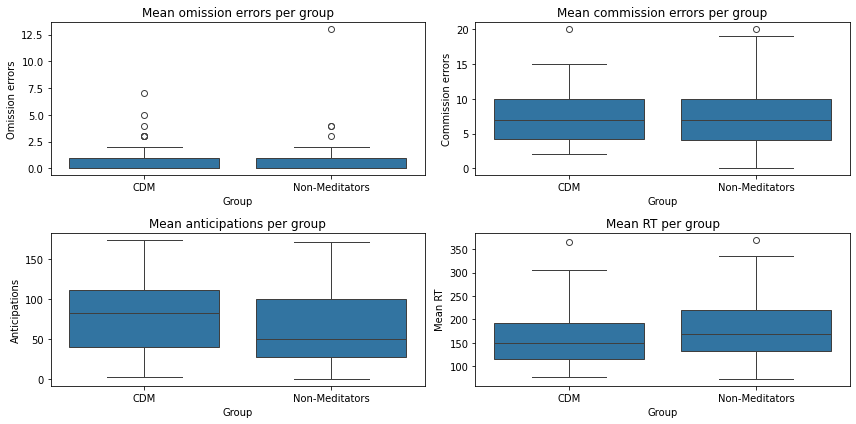

In [26]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create a boxplot for omission Errors
plt.subplot(2, 2, 1)
sns.boxplot(x='style', y='om_errors', data=sart_data, color='tab:blue')
plt.title('Mean omission errors per group')
plt.xlabel('Group')
plt.ylabel('Omission errors')

# Create a boxplot for commission Errors
plt.subplot(2, 2, 2)
sns.boxplot(x='style', y='com_errors', data=sart_data, color='tab:blue')
plt.title('Mean commission errors per group')
plt.xlabel('Group')
plt.ylabel('Commission errors')

# Create a boxplot for anticipations
plt.subplot(2, 2, 3)
sns.boxplot(x='style', y='anticipations', data=sart_data, color='tab:blue')
plt.title('Mean anticipations per group')
plt.xlabel('Group')
plt.ylabel('Anticipations')

# Create a boxplot for mean RT
plt.subplot(2, 2, 4)
sns.boxplot(x='style', y='mean_RT', data=sart_data, color='tab:blue')
plt.title('Mean RT per group')
plt.xlabel('Group')
plt.ylabel('Mean RT')

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('boxplots.pdf')

# Show the plot
plt.show()

Graphic overview of the mean comission errors for each part of the experiment per group.

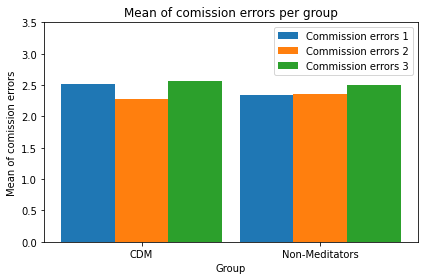

In [28]:
# Calculate the mean of com_errors_1, com_errors_2, and com_errors_3 for each group
grouped_data = sart_data.groupby('style')[['com_errors_1', 'com_errors_2', 'com_errors_3']].mean().reset_index()

# Plotting a bar chart
n_groups = 2

fig, ax = plt.subplots()

# Define the bar width
index = np.arange(n_groups)
bar_width = 0.3

# Adjust error bar properties
error_config = {'ecolor': '0.3'}

# Create bars for each com error
rects1 = ax.bar(index, grouped_data['com_errors_1'], bar_width,
                color='tab:blue',
                error_kw=error_config,
                label='Commission errors 1')

rects2 = ax.bar(index + bar_width, grouped_data['com_errors_2'], bar_width,
                color='tab:orange',
                error_kw=error_config,
                label='Commission errors 2')

rects2 = ax.bar(index + (2*bar_width), grouped_data['com_errors_3'], bar_width,
                color='tab:green',
                error_kw=error_config,
                label='Commission errors 3')

# Adding labels and title
ax.set_xlabel('Group')
ax.set_ylabel('Mean of comission errors')
ax.set_title('Mean of comission errors per group')
ax.set_xticks(index + bar_width)
plt.ylim(0, 3.5)
ax.set_xticklabels(('CDM', 'Non-Meditators'))
ax.legend()

# Show the plot
fig.tight_layout()
plt.show()

# Save the plot as pdf
fig.savefig('com_error_group_part.pdf')

Tabular summary of mean omission errors, mean commission errors, mean anticipations, and mean RT per group.

In [27]:
grouped_means = sart_data.groupby('style')[['om_errors', 'com_errors', 'com_errors_1', 'com_errors_2', 'com_errors_3', 'anticipations', 'mean_RT', 'sd_RT']].mean()
grouped_means

,om_errors,com_errors,com_errors_1,com_errors_2,com_errors_3,anticipations,mean_RT,sd_RT
style,,,,,,,,
CDM,0.838710,7.354839,2.516129,2.274194,2.564516,78.096774,158.250161,101.046190
Non-Meditators,0.728571,7.200000,2.342857,2.357143,2.500000,62.057143,183.072357,102.169303


---

## Statistical analysis
### Test for normal distribution
The use of the independent t-test assumes that the data are normally distributed within the two groups. The Shapiro-Wilk test is employed to test whether the data are normally distributed.

In [38]:
# Split the data into two groups based on 'style'
CDM_data = sart_data[sart_data['style'] == 'CDM']
NM_data = sart_data[sart_data['style'] == 'Non-Meditators']

# Variables to check for normality
variables = ['om_errors', 'com_errors', 'anticipations', 'mean_RT']

# Perform Shapiro-Wilk test for CDM group
print("Shapiro-Wilk Test for CDM Group:")
for var in variables:
    if var in CDM_data.columns:
        stat, p_value = shapiro(CDM_data[var].dropna())
        print(f'{var}: Statistic = {stat}, p-value = {p_value}')
print("\n")

# Perform Shapiro-Wilk test for Non-Meditators group
print("Shapiro-Wilk Test for Non-Meditators Group:")
for var in variables:
    if var in NM_data.columns:
        stat, p_value = shapiro(NM_data[var].dropna())
        print(f'{var}: Statistic = {stat}, p-value = {p_value}')

Shapiro-Wilk Test for CDM Group:
om_errors: Statistic = 0.6598843336105347, p-value = 1.032357116459437e-10
com_errors: Statistic = 0.9415878057479858, p-value = 0.005357861518859863
anticipations: Statistic = 0.9695890545845032, p-value = 0.1266755610704422
mean_RT: Statistic = 0.9191399812698364, p-value = 0.0005687428638339043


Shapiro-Wilk Test for Non-Meditators Group:
om_errors: Statistic = 0.4255163073539734, p-value = 4.458252462271077e-15
com_errors: Statistic = 0.9591442346572876, p-value = 0.02246110886335373
anticipations: Statistic = 0.9403409361839294, p-value = 0.0023369609843939543
mean_RT: Statistic = 0.9473162889480591, p-value = 0.005259326193481684


The Shapiro-Wilk test checks the null hypothesis that the data are normally distributed. A p-value less than 0.05 indicates that we reject the null hypothesis, suggesting that the data is not normally distributed.

**CDM Group**

- **Omission errors**: The p-value is much less than 0.05, indicating that the data for `om_errors` in the CDM group are **not normally distributed**.
- **Commission errors**: The p-value is less than 0.05, indicating that the data for `com_errors` in the CDM group are **not normally distributed**.
- **Anticipations**: The p-value is greater than 0.05, indicating that we fail to reject the null hypothesis. Thus, the data for `anticipations` in the CDM group can be considered **normally distributed**.
- **RT**: The p-value is less than 0.05, indicating that the data for `mean_RT` in the CDM group are **not normally distributed**.

**Non-Meditators Group**

- **Omission errors**: The p-value is much less than 0.05, indicating that the data for `om_errors` in the Non-Meditators group are **not normally distributed**.
- **Commission errors**: The p-value is less than 0.05, indicating that the data for `com_errors` in the Non-Meditators group are **not normally distributed**.
- **Anticipations**: The p-value is less than 0.05, indicating that the data for `anticipations` in the Non-Meditators group are **not normally distributed**.
- **RT**: The p-value is less than 0.05, indicating that the data for `mean_RT` in the Non-Meditators group are **not normally distributed**.

**Summary**

- For the CDM Group, only `anticipations` data are normally distributed. All other variables are not normally distributed.
- For the Non-Meditators Group, none of the variables are normally distributed.

### Graphic test for normal distribution
In addition to the Shapiro-Wilk test, histograms and Q-Q plots are plotted to visually assess normality.

Plots for CDM Group:


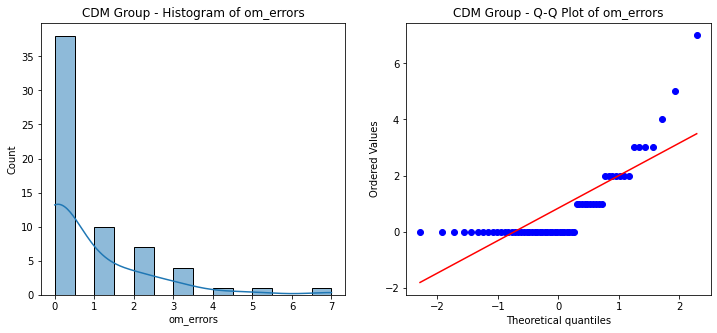

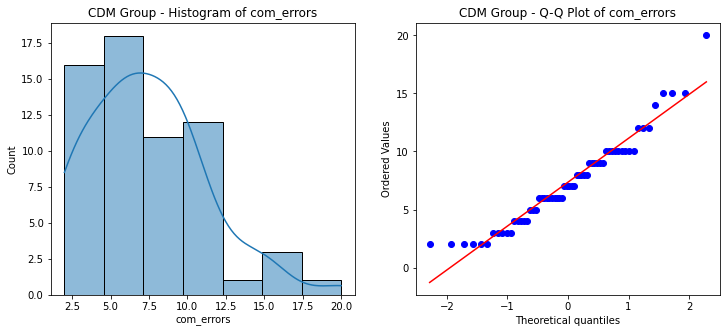

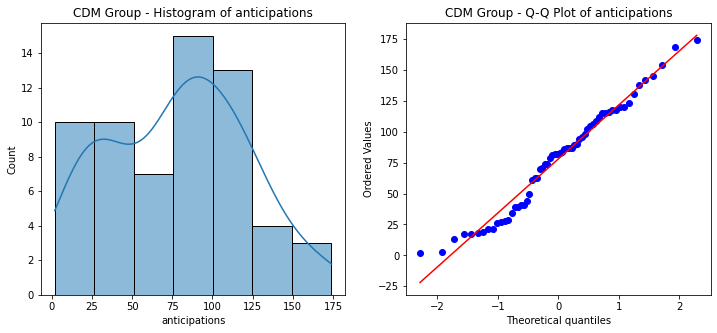

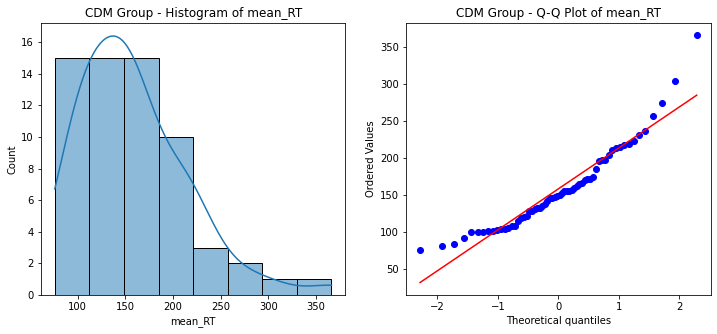

Plots for Non-Meditators Group:


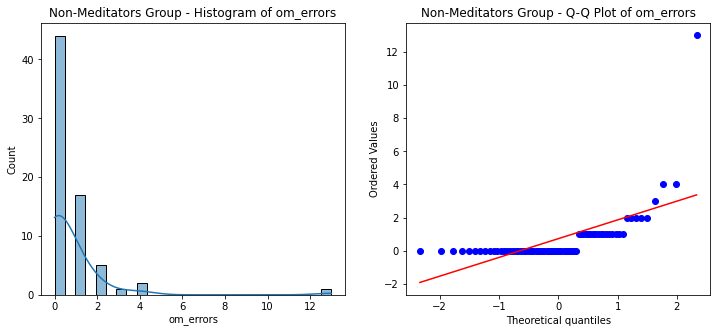

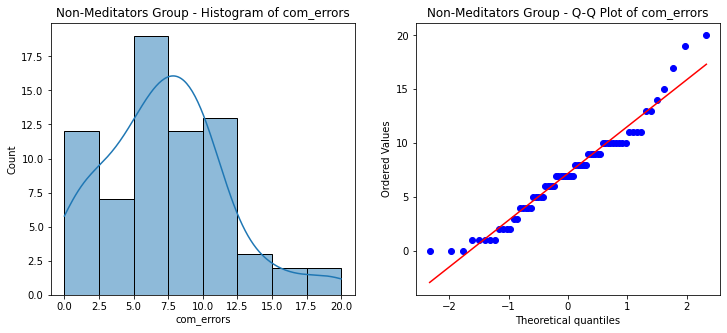

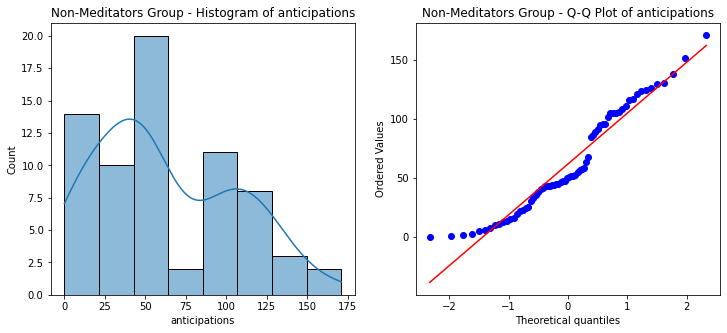

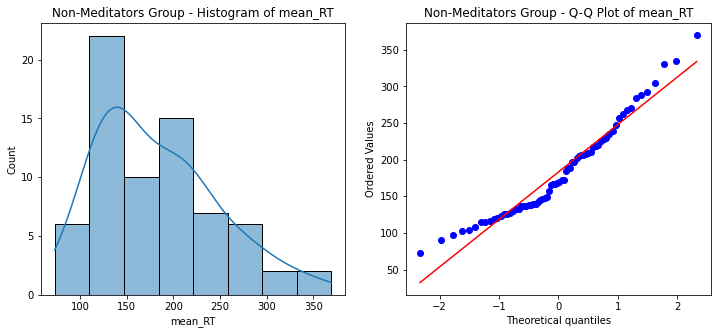

In [39]:
# Histograms and Q-Q plots for CDM group
print("Plots for CDM Group:")
for var in variables:
    if var in CDM_data.columns:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(CDM_data[var].dropna(), kde=True)
        plt.title(f'CDM Group - Histogram of {var}')

        plt.subplot(1, 2, 2)
        stats.probplot(CDM_data[var].dropna(), dist="norm", plot=plt)
        plt.title(f'CDM Group - Q-Q Plot of {var}')

        plt.show()

# Histograms and Q-Q plots for Non-Meditators group
print("Plots for Non-Meditators Group:")
for var in variables:
    if var in NM_data.columns:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(NM_data[var].dropna(), kde=True)
        plt.title(f'Non-Meditators Group - Histogram of {var}')

        plt.subplot(1, 2, 2)
        stats.probplot(NM_data[var].dropna(), dist="norm", plot=plt)
        plt.title(f'Non-Meditators Group - Q-Q Plot of {var}')

        plt.show()

Given that many of the variables are not normally distributed, using parametric tests (which assume normality) might not be appropriate. Instead, the Mann-Whitney U test, a non-parametric test (which does not assume normality), is used to compare two groups.

### Mann-Whitney *U* tests
Mann-Whitney *U* tests are performed to determine significant differences in error rates, anticipations, and mean RTs between the two groups.

In [54]:
# Variables to test
var_mwu = ['om_errors', 'com_errors', 'com_errors_1', 'com_errors_2', 'com_errors_3', 'anticipations', 'mean_RT']

# Perform Mann-Whitney U test
print("Mann-Whitney U Test Results:")
for var in var_mwu:
    if var in CDM_data.columns and var in NM_data.columns:
        stat, p_value = mannwhitneyu(CDM_data[var].dropna(), NM_data[var].dropna(), alternative='two-sided')
        print(f'{var}: Statistic = {stat}, p-value = {p_value}')

Mann-Whitney U Test Results:
om_errors: Statistic = 2277.5, p-value = 0.5734407888161505
com_errors: Statistic = 2205.5, p-value = 0.8727124957207193
com_errors_1: Statistic = 2302.0, p-value = 0.5413841509488531
com_errors_2: Statistic = 2073.0, p-value = 0.6540926271202876
com_errors_3: Statistic = 2230.0, p-value = 0.7830717706866275
anticipations: Statistic = 2592.0, p-value = 0.05460680089741045
mean_RT: Statistic = 1677.5, p-value = 0.024878057665260477


**Summary**

- **No significant difference in the error rates** betweeen the two groups.
- No significant difference in anticipations between the two groups for a significance level of 0.05, but **significant difference in anticipations for a significance level of 0.1** (weak evidence).
- **Significant differences in RT** between the two groups.

### <span style="color:red">Independent t-test
<span style="color:red"> Anticipations are normally distributed. An independent t-test is performed to determine a significant difference in anticipations between the two groups.

#### <span style="color:red"> Anticipations

In [114]:
# Separate data into two groups
CDM_anticipation = sart_data[sart_data['style'] == 'CDM']['anticipations']
NM_anticipation = sart_data[sart_data['style'] == 'Non-Meditators']['anticipations']

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(CDM_anticipation, NM_anticipation)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in the anticipations between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the anticipations between the groups.")

T-statistic: 2.122274956098658
P-value: 0.0357113780883493
Reject the null hypothesis: There is a significant difference in the anticipations between the groups.


<span style="color:red"> **Summary**

<span style="color:red"> Significant differences in anticipations between the two groups.

### <span style="color:red">ANCOVA for difference in errors with RT as covariate

In [68]:
# Fit ANCOVA model
model = sm.formula.ols('com_errors ~ style + mean_RT', data=sart_data).fit()

# Print the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Print model summary
print(model.summary())

               sum_sq     df          F    PR(>F)
style        8.665053    1.0   0.614782  0.434430
mean_RT    365.200081    1.0  25.910780  0.000001
Residual  1818.193467  129.0        NaN       NaN
                            OLS Regression Results                            
Dep. Variable:             com_errors   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     12.98
Date:                Sun, 14 Jul 2024   Prob (F-statistic):           7.29e-06
Time:                        22:39:33   Log-Likelihood:                -360.40
No. Observations:                 132   AIC:                             726.8
Df Residuals:                     129   BIC:                             735.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
          

 <span style="color:red">**ANCOVA Results Interpretation**

1. *Dependent Variable: com_errors*
    - This is the dependent variable, indicating that the model is predicting commission errors.


2. *R-squared*
    - 0.230: This indicates that approximately 23% of the variance in the dependent variable (com_errors) can be explained by the model.
    - Adj. R-squared: 0.218 is the adjusted R-squared which accounts for the number of predictors in the model. It is slightly lower than R-squared, indicating that not all predictors may be contributing significantly to the model.


3. *F-statistic and Prob (F-statistic)*
    - 19.08 and 5.60e-08: The F-statistic tests the overall significance of the model. The very low p-value (5.60e-08) indicates that the model is statistically significant.


4. *Coefficients and Interpretation*
    - Intercept: coef: 12.5344, std err: 0.955, t: 13.121, P>|t|: 0.000: The intercept represents the estimated number of commission errors when all predictors are zero. The high t-value and low p-value indicate that the intercept is significantly different from zero.
    - style[T.Non-Meditators]: coef: 0.4561, std err: 0.637, t: 0.716, P>|t|: 0.475: This coefficient represents the **difference in commission errors between non-meditators and the reference group (CDM)**. The positive coefficient suggests that non-meditators have slightly more commission errors than the reference group, but the **high p-value (0.475) indicates that this difference is not statistically significant**.
    - mean_RT: coef: -0.0327, std err: 0.005, t: -6.162, P>|t|: 0.000: This coefficient represents the **effect of mean response time on commission errors**. The negative coefficient indicates that as mean response time increases, commission errors decrease. The **very low p-value indicates that this effect is statistically significant**.


5. *Other Statistics*
    - Omnibus and Prob(Omnibus): 9.545 and 0.008: These test the null hypothesis that the residuals are normally distributed. A low p-value suggests that the residuals may not be perfectly normal.
    - Durbin-Watson: 2.140: This statistic tests for autocorrelation in the residuals. Values around 2 suggest no autocorrelation.
    - Jarque-Bera (JB) and Prob(JB): 9.485 and 0.00872: Similar to the Omnibus test, these assess the normality of residuals. A low p-value indicates potential non-normality.
    - Skew: 0.598: Indicates some skewness in the residuals.
    - Kurtosis: 3.553: Indicates the peakedness of the residual distribution.
    - Cond. No.: 557: Indicates potential multicollinearity issues if the value is very high (generally above 30). A value of 557 might warrant further investigation.

**Conclusion**

- The **model significantly explains variance in commission errors**.
- **mean_RT is a significant predictor**, indicating that response time has a strong, significant effect on commission errors.
- The **group membership does not significantly influence commission errors when controlling for mean response time**.
- The diagnostic statistics suggest some potential issues with normality and possible multicollinearity, which may need further exploration.

### Influence of confounding variables
The potential influence of the confounding variables (`screentime`, `socialmedia`, `computergames`, `exercise`, `sleep` and `mood`) on differences in error rates, anticipations, and RT between the two groups is assessed.

#### Correlation analysis
For the continuous variables `screentime` and `socialmedia` the Spearman correlation (non-parametric version of Pearson correlation) coefficients and p-values are calculated and the correlation matrix is shown.

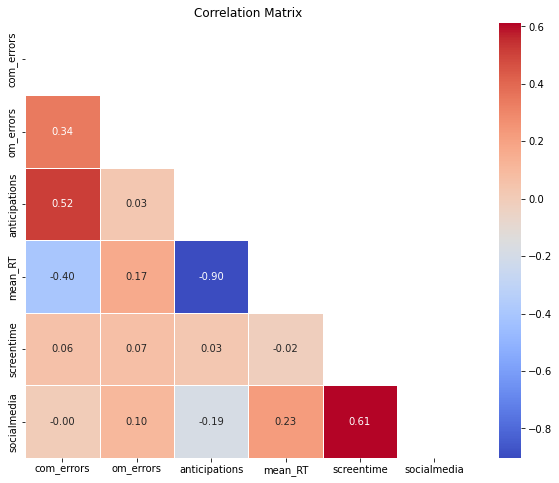


Correlation Coefficients and P-values:
   Variable 1    Variable 2  Correlation Coefficient      P-value
   com_errors     om_errors                 0.341751 6.058565e-05
   com_errors anticipations                 0.516653 2.273793e-10
   com_errors       mean_RT                -0.402161 1.753509e-06
   com_errors    screentime                 0.060321 4.920406e-01
   com_errors   socialmedia                -0.002800 9.745830e-01
    om_errors anticipations                 0.028764 7.433673e-01
    om_errors       mean_RT                 0.165450 5.797465e-02
    om_errors    screentime                 0.068336 4.362387e-01
    om_errors   socialmedia                 0.102973 2.400175e-01
anticipations       mean_RT                -0.902883 1.673738e-49
anticipations    screentime                 0.031576 7.192834e-01
anticipations   socialmedia                -0.186731 3.204415e-02
      mean_RT    screentime                -0.020503 8.154894e-01
      mean_RT   socialmedia         

In [67]:
# Calculate the correlation matrix for the relevant variables
variables = ['com_errors', 'om_errors', 'anticipations', 'mean_RT', 'screentime', 'socialmedia']
correlation_matrix = sart_data[variables].corr(method='spearman')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Draw the heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Calculate correlation coefficients and p-values
def calculate_correlation_and_pvalue(x, y):
    return stats.spearmanr(x, y)

results = []
for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i < j:  # To avoid duplicate comparisons
            coef, p_value = calculate_correlation_and_pvalue(sart_data[var1], sart_data[var2])
            results.append({
                'Variable 1': var1,
                'Variable 2': var2,
                'Correlation Coefficient': coef,
                'P-value': p_value
            })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)
            
# Display the table
print("\nCorrelation Coefficients and P-values:")
print(results_df.to_string(index=False))

#### Interpretation of correlation analysis

***Influence of*** `screentime`
    
No significant correlations found.
    
***Influence of*** `socialmedia`
- commission errors: no significant correlation
- omission errors: no significant correlation
- anticipations: very weak negative correlation (-0.19), statistically significant (0.03) ⟶ higher social media usage is associated with fewer anticipations
- RT: weak positive correlation (0.23), statistically significant (0.009) ⟶ higher social media usage is associated with longer mean reaction time

In conclusion, **social media usage shows a weak but statistically significant influence on** `anticipations` **and** `mean_RT`. In contrast, screen time does not exhibit any significant correlations with the dependent variables in this dataset.

#### Stratified Mann-Whitney *U* tests
To check for a potential influence of the categorical variables `computergames`, `exercise`, `sleep`, or `mood` on differences between meditators and non-meditators, stratified Mann-Whitney *U* tests (variables are not normally distributed) are conducted.

Stratified analysis involves dividing the data into strata (subgroups) based on levels of the confounding variable.

In [64]:
# Define the confounding variables
confounding_variables = ['computergames', 'exercise', 'sleep', 'mood']

# Define the groups to compare (CDM vs Non-Meditators)
CDM_data = sart_data[sart_data['style'] == 'CDM']
NM_data = sart_data[sart_data['style'] == 'Non-Meditators']

# Variables to test using Mann-Whitney U test
var_mwu = ['om_errors', 'com_errors', 'anticipations', 'mean_RT']

# Perform Mann-Whitney U test stratified by each confounding variable
for conf_var in confounding_variables:
    # Get unique values of the confounding variable
    conf_var_levels = sart_data[conf_var].unique()
    
    print(f"\nMann-Whitney U Test Results stratified by {conf_var}:")
    
    for level in conf_var_levels:
        # Split data into two groups based on 'style' and the current level of conf_var
        CDM_subgroup = CDM_data[CDM_data[conf_var] == level]
        NM_subgroup = NM_data[NM_data[conf_var] == level]
        
        # Perform Mann-Whitney U test for each variable of interest
        for var in var_mwu:
            if var in CDM_subgroup.columns and var in NM_subgroup.columns:
                CDM_values = CDM_subgroup[var].dropna()
                NM_values = NM_subgroup[var].dropna()
                
                # Check if both groups have data before performing the test
                if len(CDM_values) > 0 and len(NM_values) > 0:
                    stat, p_value = mannwhitneyu(CDM_values, NM_values, alternative='two-sided')
                    print(f'Level {level}: {var}: Statistic = {stat}, p-value = {p_value}')
                else:
                    print(f'Level {level}: {var}: Insufficient data for Mann-Whitney U test')


Mann-Whitney U Test Results stratified by computergames:
Level 1: om_errors: Statistic = 1240.5, p-value = 0.41407780309940023
Level 1: com_errors: Statistic = 1198.0, p-value = 0.6929500813103389
Level 1: anticipations: Statistic = 1396.5, p-value = 0.06385419713801621
Level 1: mean_RT: Statistic = 888.0, p-value = 0.06027943096108894
Level 2: om_errors: Statistic = 104.5, p-value = 1.0
Level 2: com_errors: Statistic = 89.5, p-value = 0.5094397902002716
Level 2: anticipations: Statistic = 125.5, p-value = 0.3826158589359915
Level 2: mean_RT: Statistic = 76.0, p-value = 0.21355772865776912
Level 3: om_errors: Statistic = 6.0, p-value = 1.0
Level 3: com_errors: Statistic = 6.5, p-value = 1.0
Level 3: anticipations: Statistic = 4.0, p-value = 0.6285714285714286
Level 3: mean_RT: Statistic = 7.0, p-value = 0.8571428571428571

Mann-Whitney U Test Results stratified by exercise:
Level 4: om_errors: Statistic = 535.5, p-value = 0.40333263162951216
Level 4: com_errors: Statistic = 575.5, p-v

#### Interpretation of Mann-Whitney *U* test results

***Computergames***

None of the p-values are below the common significance threshold (0.05) for none of the 3 levels, indicating no statistically significant differences between `CDM` and `Non-Meditators` and no influence of the variable `computergames`.

***Exercise***
- Only for level 3 ("once a week"), the variable `om_errors` shows a significant difference (p-value = 0.018), suggesting a difference in omission errors between the two groups at this exercise level. No other variables show significant differences.
- There is no significant difference in any of the variables between the two groups for levels 2 and 4.
- For level 1 ("I don't exercise"), there is insufficient data for testing.

***Sleep***
- Level 3 (<=8 hours): The variables `anticipations` (p-value = 0.046) and `mean_RT` (p-value = 0.031) show significant differences, suggesting a difference between the groups for these variables. No other significant differences.
- There is no significant difference in any of the variables between the two groups for levels 1, 2, and 4.
- For level 5 (> 9hours) there is insufficient data for testing.

***Mood***
- Level 2: The variable `com_errors` (p-value = 0.035) shows significant difference, suggesting a difference between the groups for these variables.
- There is no significant difference in any of the variables between the two groups for levels 3, 4, 5, 6, 7, 8, 9.
- For level 10 there is insufficient data for testing.

#### Summary and Implications
- Exercise Level 3: The significant difference in `om_errors` indicates that **exercise might influence the number of omission errors differently between meditators and non-meditators**.
- Sleep Level 3: Significant differences in `anticipations` and `mean_RT` suggest that **sleep duration may impact anticipations and reaction times differently between the groups**.
- Mood Level 2: The significant difference in `com_errors` suggests that **mood might influence commission errors between the two groups**.

These findings indicate that **exercise, sleep, and mood could potentially moderate the differences in SART performance between 'CDM' and 'Non-Meditators'**. Therefore, these factors should be carefully controlled or considered in future research examining the cognitive impacts of meditation styles.

---

## Exploratory analysis
**Differences within the CDM group with regard to regularity, experience, and duration**

To ascertain whether there are differences in SART performance between different groups of meditators, further analyses are conducted. Meditators with varying levels of experience, regularity, and duration of practice are compared.
### Experience
Differences in error rates, anticipations, and RT within the CDM group between participants with different experience levels

#### Test for normal distribution

The Shapiro-Wilk test is employed to test whether the data are normally distributed.

In [62]:
# Split the data into four groups based on 'experience'
exp_1_data = sart_data[sart_data['experience'] == 1]
exp_2_data = sart_data[sart_data['experience'] == 2]
exp_3_data = sart_data[sart_data['experience'] == 3]
exp_4_data = sart_data[sart_data['experience'] == 4]

# Variables to check for normality
variables = ['om_errors', 'com_errors', 'anticipations', 'mean_RT']

# Perform Shapiro-Wilk test for group with experience level 1
print("Shapiro-Wilk Test for group with experience level 1:")
for var in variables:
    if var in exp_1_data.columns:
        stat, p_value = shapiro(exp_1_data[var].dropna())
        print(f'{var}: Statistic = {stat}, p-value = {p_value}')
print("\n")

# Perform Shapiro-Wilk test for group with experience level 2
print("Shapiro-Wilk Test for group with experience level 2:")
for var in variables:
    if var in exp_2_data.columns:
        stat, p_value = shapiro(exp_2_data[var].dropna())
        print(f'{var}: Statistic = {stat}, p-value = {p_value}')
print("\n")
        
# Perform Shapiro-Wilk test for group with experience level 3
print("Shapiro-Wilk Test for group with experience level 3:")
for var in variables:
    if var in exp_3_data.columns:
        stat, p_value = shapiro(exp_3_data[var].dropna())
        print(f'{var}: Statistic = {stat}, p-value = {p_value}')
print("\n")

# Perform Shapiro-Wilk test for group with experience level 4
print("Shapiro-Wilk Test for group with experience level 4:")
for var in variables:
    if var in exp_4_data.columns:
        stat, p_value = shapiro(exp_4_data[var].dropna())
        print(f'{var}: Statistic = {stat}, p-value = {p_value}')

Shapiro-Wilk Test for group with experience level 1:
om_errors: Statistic = 0.827140212059021, p-value = 0.041472118347883224
com_errors: Statistic = 0.8206983208656311, p-value = 0.03508966043591499
anticipations: Statistic = 0.9154460430145264, p-value = 0.35587266087532043
mean_RT: Statistic = 0.8988550901412964, p-value = 0.24543850123882294


Shapiro-Wilk Test for group with experience level 2:
om_errors: Statistic = 0.7406470775604248, p-value = 0.0001768945949152112
com_errors: Statistic = 0.9267927408218384, p-value = 0.15112519264221191
anticipations: Statistic = 0.9034346342086792, p-value = 0.05615838244557381
mean_RT: Statistic = 0.9183183908462524, p-value = 0.10535158962011337


Shapiro-Wilk Test for group with experience level 3:
om_errors: Statistic = 0.5679951906204224, p-value = 9.200313684232242e-07
com_errors: Statistic = 0.9482300281524658, p-value = 0.31525102257728577
anticipations: Statistic = 0.9178658127784729, p-value = 0.07866501808166504
mean_RT: Statistic 

**Interpretation of the Shapiro-Wilk test results**

exp group 1
- om errors: **not normal**
- com errors: **not normal**
- anticipations: normal
- RT: normal

exp group 2
- om errors: **not normal**
- com errors: normal
- anticipations: normal
- RT: normal

exp group 3
- om errors: **not normal**
- com errors: normal
- anticipations: normal
- RT: normal

exp group 4
- om errors: **not normal**
- com errors: normal
- anticipations: normal
- RT: normal

#### Kruskal-Wallis H test

Determine whether there are statistically significant differences between two or more groups of the independent variable `experience` on the dependent variables (om_errors, com_errors, anticipations, mean_RT).

It is the non-parametric alternative to the ANOVA.

In [72]:
# Perform Kruskal-Wallis H test for each dependent variable
kruskal_om_errors = stats.kruskal(
    *[sart_data[sart_data['experience'] == exp]['om_errors'] for exp in [1,2,3,4]]
)
kruskal_com_errors = stats.kruskal(
    *[sart_data[sart_data['experience'] == exp]['com_errors'] for exp in [1,2,3,4]]
)
kruskal_anticipations = stats.kruskal(
    *[sart_data[sart_data['experience'] == exp]['anticipations'] for exp in [1,2,3,4]]
)
kruskal_mean_RT = stats.kruskal(
    *[sart_data[sart_data['experience'] == exp]['mean_RT'] for exp in [1,2,3,4]]
)

print("Kruskal-Wallis H Test Results")
print("om_errors:", kruskal_om_errors)
print("com_errors:", kruskal_com_errors)
print("anticipations:", kruskal_anticipations)
print("mean_RT:", kruskal_mean_RT)

# If Kruskal-Wallis test indicates significant differences, perform post-hoc Mann-Whitney U tests <- evtl. rausnehmen
if kruskal_om_errors.pvalue < 0.05:
    print("\nPost-hoc Mann-Whitney U tests for om_errors")
    experience_levels = sart_data['experience'].unique()
    for i in range(len(experience_levels)):
        for j in range(i + 1, len(experience_levels)):
            exp1 = experience_levels[i]
            exp2 = experience_levels[j]
            u_stat, p_value = stats.mannwhitneyu(
                sart_data[sart_data['experience'] == exp1]['om_errors'],
                sart_data[sart_data['experience'] == exp2]['om_errors']
            )
            print(f"Experience {exp1} vs Experience {exp2}: U={u_stat}, p={p_value}")

if kruskal_com_errors.pvalue < 0.05:
    print("\nPost-hoc Mann-Whitney U tests for com_errors")
    experience_levels = sart_data['experience'].unique()
    for i in range(len(experience_levels)):
        for j in range(i + 1, len(experience_levels)):
            exp1 = experience_levels[i]
            exp2 = experience_levels[j]
            u_stat, p_value = stats.mannwhitneyu(
                sart_data[sart_data['experience'] == exp1]['com_errors'],
                sart_data[sart_data['experience'] == exp2]['com_errors']
            )
            print(f"Experience {exp1} vs Experience {exp2}: U={u_stat}, p={p_value}")

if kruskal_anticipations.pvalue < 0.05:
    print("\nPost-hoc Mann-Whitney U tests for anticipations")
    experience_levels = sart_data['experience'].unique()
    for i in range(len(experience_levels)):
        for j in range(i + 1, len(experience_levels)):
            exp1 = experience_levels[i]
            exp2 = experience_levels[j]
            u_stat, p_value = stats.mannwhitneyu(
                sart_data[sart_data['experience'] == exp1]['anticipations'],
                sart_data[sart_data['experience'] == exp2]['anticipations']
            )
            print(f"Experience {exp1} vs Experience {exp2}: U={u_stat}, p={p_value}")

if kruskal_mean_RT.pvalue < 0.05:
    print("\nPost-hoc Mann-Whitney U tests for mean_RT")
    experience_levels = sart_data['experience'].unique()
    for i in range(len(experience_levels)):
        for j in range(i + 1, len(experience_levels)):
            exp1 = experience_levels[i]
            exp2 = experience_levels[j]
            u_stat, p_value = stats.mannwhitneyu(
                sart_data[sart_data['experience'] == exp1]['mean_RT'],
                sart_data[sart_data['experience'] == exp2]['mean_RT']
            )
            print(f"Experience {exp1} vs Experience {exp2}: U={u_stat}, p={p_value}")

Kruskal-Wallis H Test Results
om_errors: KruskalResult(statistic=6.915540872592264, pvalue=0.07463905237201801)
com_errors: KruskalResult(statistic=1.2259482664956542, pvalue=0.7467878085921191)
anticipations: KruskalResult(statistic=1.610784091005969, pvalue=0.6569470789664809)
mean_RT: KruskalResult(statistic=5.308182721959071, pvalue=0.1505723070548104)


The Kruskal-Wallis tests indicate **no significant differences between different experience levels within the CDM group for any of the dependent variables**.

<span style="color:red"> post-hoc Mann-Whitney U tests rausnehmen

#### Post-hoc power analysis

In [82]:
# Parameters for power analysis
effect_size = 0.5
alpha = 0.05
power = 0.80
k = 4

# Calculate the required sample size
analysis = smp.FTestAnovaPower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=k)

print(f"Required sample size per group: {sample_size:.2f}")

Required sample size per group: 47.70


#### Frequencies in experience groups

In [73]:
exp_groups_2 = sart_data.groupby(['experience'], sort=True).size().reset_index(name='Count')
exp_groups_2

,experience,Count
0,0,70
1,1,9
2,2,19
3,3,21
4,4,13


<span style="color:red">Sample size too small

In [75]:
grouped_means_2 = sart_data.groupby('experience')[['om_errors', 'com_errors', 'com_errors_1', 'com_errors_2', 'com_errors_3', 'anticipations', 'mean_RT']].mean()
grouped_means_2

,om_errors,com_errors,com_errors_1,com_errors_2,com_errors_3,anticipations,mean_RT
experience,,,,,,,
0,0.728571,7.200000,2.342857,2.357143,2.500000,62.057143,183.072357
1,1.111111,7.111111,2.222222,2.000000,2.888889,64.777778,183.191667
2,1.421053,8.105263,2.789474,2.684211,2.631579,82.947368,174.316579
3,0.428571,6.761905,2.619048,2.095238,2.047619,75.285714,145.662619
4,0.461538,7.384615,2.153846,2.153846,3.076923,84.769231,137.835000


### Regularity
Differences in error rates, anticipations, and RT within the CDM group between participants with different regularity levels

#### Frequencies in regularity groups

In [76]:
reg_groups_2 = sart_data.groupby(['regularity'], sort=True).size().reset_index(name='Count')
reg_groups_2

,regularity,Count
0,1,70
1,2,44
2,3,3
3,4,7
4,5,8


<span style="color:red"> hier direkt aufhören, weil Gruppen 2-4 nicht groß genug?

#### Test for normal distribution

The Shapiro-Wilk test is employed to test whether the data are normally distributed.

In [77]:
# Split the data into four groups based on 'regularity'
reg_1_data = sart_data[sart_data['regularity'] == 2]
reg_2_data = sart_data[sart_data['regularity'] == 3]
reg_3_data = sart_data[sart_data['regularity'] == 4]
reg_4_data = sart_data[sart_data['regularity'] == 5]

# Variables to check for normality
variables = ['om_errors', 'com_errors', 'anticipations', 'mean_RT']

# Perform Shapiro-Wilk test for group with regularity level 1
print("Shapiro-Wilk Test for group with regularity level 1:")
for var in variables:
    if var in reg_1_data.columns:
        stat, p_value = shapiro(reg_1_data[var].dropna())
        print(f'{var}: Statistic = {stat}, p-value = {p_value}')
print("\n")

# Perform Shapiro-Wilk test for group with regularity level 2
print("Shapiro-Wilk Test for group with regularity level 2:")
for var in variables:
    if var in reg_2_data.columns:
        stat, p_value = shapiro(reg_2_data[var].dropna())
        print(f'{var}: Statistic = {stat}, p-value = {p_value}')
print("\n")
        
# Perform Shapiro-Wilk test for group with regularity level 3
print("Shapiro-Wilk Test for group with regularity level 3:")
for var in variables:
    if var in reg_3_data.columns:
        stat, p_value = shapiro(reg_3_data[var].dropna())
        print(f'{var}: Statistic = {stat}, p-value = {p_value}')
print("\n")

# Perform Shapiro-Wilk test for group with regularity level 4
print("Shapiro-Wilk Test for group with regularity level 4:")
for var in variables:
    if var in reg_4_data.columns:
        stat, p_value = shapiro(reg_4_data[var].dropna())
        print(f'{var}: Statistic = {stat}, p-value = {p_value}')

Shapiro-Wilk Test for group with regularity level 1:
om_errors: Statistic = 0.6321741938591003, p-value = 2.9131157486261827e-09
com_errors: Statistic = 0.9340014457702637, p-value = 0.014424124732613564
anticipations: Statistic = 0.9587129950523376, p-value = 0.11648748070001602
mean_RT: Statistic = 0.9030559659004211, p-value = 0.0013527589617297053


Shapiro-Wilk Test for group with regularity level 2:
om_errors: Statistic = 0.7500000596046448, p-value = -9.106917104872991e-07
com_errors: Statistic = 1.0, p-value = 0.999998927116394
anticipations: Statistic = 0.9390738606452942, p-value = 0.5236609578132629
mean_RT: Statistic = 0.8337275385856628, p-value = 0.19784823060035706


Shapiro-Wilk Test for group with regularity level 3:
om_errors: Statistic = 0.7319743633270264, p-value = 0.00819335412234068
com_errors: Statistic = 0.8986455798149109, p-value = 0.3228583335876465
anticipations: Statistic = 0.9559692144393921, p-value = 0.7834999561309814
mean_RT: Statistic = 0.90951836109

**Interpretation of the Shapiro-Wilk test results**

reg group 1
- om errors: **not normal**
- com errors: **not normal**
- anticipations: normal
- RT: **not normal**

reg group 2
- om errors: **not normal**
- com errors: normal
- anticipations: normal
- RT: normal

reg group 3
- om errors: **not normal**
- com errors: normal
- anticipations: normal
- RT: normal

reg group 4
- om errors: **not normal**
- com errors: normal
- anticipations: normal
- RT: normal

#### <span style="color:red"> Kruskal-Wallis H test
    
Determine whether there are statistically significant differences between two or more groups of the independent variable `regularity` on the dependent variables (om_errors, com_errors, anticipations, mean_RT).

### Duration
Differences in error rates, anticipations, and RT within the CDM group between participants with different duration levels

#### Frequencies in duration groups

In [78]:
dur_groups_2 = sart_data.groupby(['duration'], sort=True).size().reset_index(name='Count')
dur_groups_2

,duration,Count
0,0,70
1,1,59
2,2,3


<span style="color:red"> hier direkt aufhören, weil nur 2 Gruppen und eine davon nur 3 participants?

#### Test for normal distribution

#### <span style="color:red"> Kruskal-Wallis H test
Determine whether there are statistically significant differences between two or more groups of the independent variable `duration` on the dependent variables (om_errors, com_errors, anticipations, mean_RT).

<span style="color:red">Hier könnte sogar wieder Mann-Whitney U test genommen werden, da nur 2 Gruppen.